### 글루온 신경망 언어 모델 

지금까지 기존 언어모델의 한계를 설명한 이유는 기존의 한계나 단점을 딥러닝이 멋지게 해결했기 때문이다.  앞서 설명한 피드 포워드(feed-forward) 신경망 그리고 임베딩으로 단어를 실수 벡터 공간으로 사영할 수 있게 되어 데이터 희소화 문제를 해결했으며, 더 나아가 일반화를 꾀할 수 있었다. 예를 들어 "빨간 자동차"가 코퍼스에 없다 하더라도 "빨간", "자동차" 두 단어의 임베딩 벡터를 평균하여 "빨간 자동차"의 벡터를 생성할 수 있을 것이다.  또한 RNN으로 장기 문맥 정보를 반영하는게 용이해졌다. 물론 RNN이 시퀀스가 길어질때 그래디언트 소실문제가 있었으나, LSTM이나 GRU로 상당부분 해결이 되었다. 게다가 기존의 비지도학습 기반의 언어모델 생성을 신경망 기반의 지도학습으로 변화시켰다.

몇마디 문장으로 기존 언어모델에서 신경망 언어모델로의 변화 특징을 기술했지만, 이 부분의 기술진보 역사가 짧은편은 아니다. 여기서는 모든 변화를 설명하기 보다는 위 단점을 해소한 하나의 신경망 언어모델을 GluonNLP를 이용해 살펴보고 몇가지 다은 언어모델을 전이학습으로 활용해보는 방법을 설명하도록 하겠다. 

신경망 언어모델로 오게 되면서 언어모델 자체로서의 의미보다는 다양한 NLP관련 모형을 만들때 임베딩과 함게 핵심적인 역할을 수행하는 딥러닝 컴포넌트의 역할을 수행하게 되었으며, 이 때문에 범용적인 다양한 언어모델이 제안되었고 이를 기반으로 한 전이학습 등으로 기계번역 등의 영역에서 성능향상을 이뤄왔다. 따라서 직접 언어모델을 생성하거나 혹은 잘 만들어진 언어모델을 사용하여 목적에 맞는 모형을 생성하는 경험은 앞으로 NLP의 영역의 어플리케이션을 만드는데 큰 도움이 될 것이다. 

In [1]:
import mxnet as mx
import gluonnlp as nlp
from mxnet.gluon import nn, rnn
import numpy as np
import mxnet as mx
from mxnet import nd, gluon, autograd
import itertools
from tqdm import tqdm
import time
import multiprocessing as mp


In [2]:
#https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py

In [3]:
#!curl https://raw.githubusercontent.com/yxtay/char-rnn-text-generation/master/data/tinyshakespeare.txt --output tinyshakespeare.txt 

In [2]:
!head tinyshakespeare.txt

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:


In [3]:
!head -35000 tinyshakespeare.txt > tinyshakespeare_train.txt

In [4]:
!tail -4999 tinyshakespeare.txt > tinyshakespeare_test.txt

In [4]:
corpus_train = list(itertools.chain.from_iterable(open('tinyshakespeare_train.txt', 'rt')))
corpus_test = list(itertools.chain.from_iterable(open('tinyshakespeare_test.txt', 'rt')))

In [5]:
batch_size = 30
seq_size = 35

In [6]:
counter = nlp.data.Counter(corpus_train)
vocab = nlp.Vocab(counter, unknown_token='<unk>',  min_freq=5)

In [7]:
#Language Model 학습을 위한 학습셋을 생성하기 위한 함수 
#주의 (seq_len, batch_size) 형태의 데이터 배치를 생성한다. 
bptt_bfy = nlp.data.batchify.CorpusBPTTBatchify(vocab, seq_size, batch_size, last_batch='discard')

In [8]:
#bptt_bfy는 list를 입력받고, mxnet.gluon.data.SimpleDataset 객체를 리턴하는 함수

train_data, test_data = [bptt_bfy(d) for d in (corpus_train, corpus_test)]

In [9]:
it = 0 
for i,j in train_data:
    #각 배치의 첫번째 데이터를 출력한다. 
    print('input : \n'+ ''.join([vocab.idx_to_token[a] for a in i[:,0].asnumpy().astype('int')]))
    print('output : \n'+ ''.join([vocab.idx_to_token[a] for a in j[:,0].asnumpy().astype('int')]))
    it += 1
    if it > 3:
        break

input : 
First Citizen:
Before we proceed an
output : 
irst Citizen:
Before we proceed any
input : 
y further, hear me speak.

All:
Spe
output : 
 further, hear me speak.

All:
Spea
input : 
ak, speak.

First Citizen:
You are 
output : 
k, speak.

First Citizen:
You are a
input : 
all resolved rather to die than to 
output : 
ll resolved rather to die than to f


In [10]:
class StandardLM(nn.HybridBlock):
    
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(StandardLM, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size 
        self.hidden_size = hidden_size 

        with self.name_scope():        
            self.embedding = nn.Embedding(input_dim=self.vocab_size, output_dim=self.embed_size)
            self.drop = nn.Dropout(0.2)
            self.encoder = rnn.LSTM(hidden_size=hidden_size, num_layers=2, dropout=0.2)
            self.decoder = nn.Dense(self.vocab_size, flatten=False)
        
    def hybrid_forward(self, F, x, hidden):
        embed = self.drop(self.embedding(x))
        lstm_out, hidden_o = self.encoder(embed, hidden)
        return(self.decoder(lstm_out), hidden_o)
    
    def begin_state(self, *args, **kwargs):
        return(self.encoder.begin_state(*args, **kwargs))


In [22]:
ctx = mx.gpu()

In [23]:
vocab_size = len(vocab.idx_to_token)
model = StandardLM(vocab_size, embed_size=200, hidden_size=200)

In [24]:
model.initialize(mx.init.Xavier(), ctx=ctx)
trainer = gluon.Trainer(model.collect_params(), 'adam')
loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [25]:
model

StandardLM(
  (decoder): Dense(None -> 67, linear)
  (encoder): LSTM(None -> 200, TNC, num_layers=2, dropout=0.2)
  (drop): Dropout(p = 0.2, axes=())
  (embedding): Embedding(67 -> 200, float32)
)

In [26]:
def evaluate(model, data_source, batch_size, ctx):
    total_L = 0.0
    ntotal = 0
    hidden = model.begin_state(batch_size, func=nd.zeros, ctx=ctx)
    for i, (data, target) in enumerate(data_source):
        data = data.as_in_context(ctx)
        target = target.as_in_context(ctx)
        output, hidden = model(data, hidden)
        hidden = [h.detach() for h in hidden]
        L = loss(output, target)
        total_L += nd.sum(L).asscalar()
        ntotal += L.size
    return(total_L / ntotal)

## Perplexity : $\exp^{- \frac{1}{n} \sum_{i=1}^n \log_2LM(w_i|w_{1:i-1})}$

In [27]:
def eval_perplexity(model, data, batch_size, ctx):
    perp = mx.metric.Perplexity(ignore_label=None)
    hidden = model.begin_state(batch_size, func=nd.zeros, ctx=ctx)
    for i, (data, target) in enumerate(data):
        data = data.as_in_context(ctx)
        target = target.as_in_context(ctx)
        output, hidden = model(data, hidden)
        hidden = [h.detach() for h in hidden]
        perp.update(target, output)
    return(perp.get()[1])

In [28]:
def train(model, train_data, epochs):
    start_train_time = time.time()
    Ltr = []
    Lte = []
    perp = []
    for epoch in range(epochs):
        hidden = model.begin_state(batch_size, func=nd.zeros, ctx=ctx)
        L = []
        for i, (data, target) in enumerate(tqdm(train_data)):
            data = data.as_in_context(ctx)
            target = target.as_in_context(ctx)
            hidden = [h.detach() for h in hidden]
            with autograd.record():
                output, hidden = model(data, hidden)
                batch_L = loss(output, target)
                L.append(batch_L.asnumpy())
            batch_L.backward()
            trainer.step(data.shape[1])
        test_loss = evaluate(model, test_data, batch_size, ctx)  
        train_loss = np.array(L).mean()
        perplexity = eval_perplexity(model, test_data, batch_size, ctx)
        
        Ltr.append(train_loss)
        Lte.append(test_loss)
        perp.append(perplexity)
        print('epoch : {} ;train loss : {} ;test loss : {} ; test perplexity  : {}'.format(epoch, train_loss, test_loss, perplexity))  
    return(Ltr, Lte, perp)

In [29]:
train_loss, test_loss, perplexity = train(model, train_data, 20)

  0%|          | 3/942 [00:00<00:32, 29.33it/s]

epoch : 0 ;train loss : 2.156374931335449 ;test loss : 1.8512018540326287 ; test perplexity  : 0.24608353309974376


  0%|          | 3/942 [00:00<00:32, 29.27it/s]

epoch : 1 ;train loss : 1.6528326272964478 ;test loss : 1.728211059203955 ; test perplexity  : 0.21636880666643651


  0%|          | 3/942 [00:00<00:31, 29.66it/s]

epoch : 2 ;train loss : 1.5264644622802734 ;test loss : 1.651648197425943 ; test perplexity  : 0.20110196464653254


  0%|          | 3/942 [00:00<00:31, 29.60it/s]

epoch : 3 ;train loss : 1.461790680885315 ;test loss : 1.6216540067565113 ; test perplexity  : 0.1923264080602213


  0%|          | 3/942 [00:00<00:31, 29.53it/s]

epoch : 4 ;train loss : 1.4215331077575684 ;test loss : 1.594846079300861 ; test perplexity  : 0.18675702921171003


  0%|          | 3/942 [00:00<00:31, 29.50it/s]

epoch : 5 ;train loss : 1.3917092084884644 ;test loss : 1.5759037324646656 ; test perplexity  : 0.18042122783385314


  0%|          | 3/942 [00:00<00:32, 29.26it/s]

epoch : 6 ;train loss : 1.3699151277542114 ;test loss : 1.5627451975663311 ; test perplexity  : 0.1768341563087865


  0%|          | 3/942 [00:00<00:31, 29.62it/s]

epoch : 7 ;train loss : 1.3523614406585693 ;test loss : 1.5570270149075256 ; test perplexity  : 0.17533362161928318


  0%|          | 3/942 [00:00<00:32, 29.33it/s]

epoch : 8 ;train loss : 1.338131308555603 ;test loss : 1.54912386524434 ; test perplexity  : 0.17326621894500038


  0%|          | 3/942 [00:00<00:31, 29.64it/s]

epoch : 9 ;train loss : 1.3263251781463623 ;test loss : 1.5399158802925468 ; test perplexity  : 0.17160997756820048


  0%|          | 3/942 [00:00<00:31, 29.63it/s]

epoch : 10 ;train loss : 1.3157912492752075 ;test loss : 1.5476586294918357 ; test perplexity  : 0.1685901722689627


  0%|          | 3/942 [00:00<00:31, 29.63it/s]

epoch : 11 ;train loss : 1.30707585811615 ;test loss : 1.544392904256429 ; test perplexity  : 0.1674097528826944


  0%|          | 3/942 [00:00<00:31, 29.63it/s]

epoch : 12 ;train loss : 1.2990243434906006 ;test loss : 1.546013604721674 ; test perplexity  : 0.16573490194632112


  0%|          | 3/942 [00:00<00:33, 27.97it/s]

epoch : 13 ;train loss : 1.29240882396698 ;test loss : 1.5487839358765967 ; test perplexity  : 0.16493288015760948


  0%|          | 3/942 [00:00<00:31, 29.46it/s]

epoch : 14 ;train loss : 1.2858871221542358 ;test loss : 1.5513646046797624 ; test perplexity  : 0.16403128751397722


  0%|          | 3/942 [00:00<00:31, 29.88it/s]

epoch : 15 ;train loss : 1.2802140712738037 ;test loss : 1.5407149142005434 ; test perplexity  : 0.16295455487812738


  0%|          | 3/942 [00:00<00:31, 29.57it/s]

epoch : 16 ;train loss : 1.275181531906128 ;test loss : 1.5456598838265776 ; test perplexity  : 0.1635148370276148


  0%|          | 3/942 [00:00<00:33, 28.27it/s]

epoch : 17 ;train loss : 1.2707302570343018 ;test loss : 1.54494518541059 ; test perplexity  : 0.16020340415765802


  0%|          | 3/942 [00:00<00:31, 29.80it/s]

epoch : 18 ;train loss : 1.2668492794036865 ;test loss : 1.544065261602688 ; test perplexity  : 0.16174261436688117


100%|██████████| 942/942 [00:34<00:00, 27.62it/s]


epoch : 19 ;train loss : 1.262573003768921 ;test loss : 1.5449989025761672 ; test perplexity  : 0.16110228806388893


In [30]:
import pandas as pd

In [31]:
%matplotlib inline

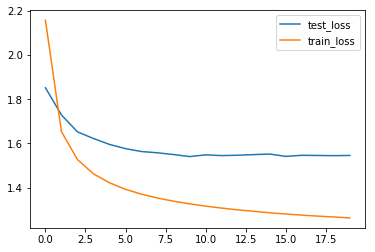

In [32]:
pd.DataFrame({"train_loss":train_loss, "test_loss":test_loss}).plot()

In [33]:
def text_generation(txt_seq, model, vocab):
    txt_seq = list(txt_seq) 
    hidden = model.begin_state(batch_size=1, func=nd.zeros, ctx=ctx)
    i = 0
    char_seq = []
    with autograd.record(train_mode=False):
        for tkn in txt_seq:
            res, hidden = model(nd.array([[vocab[tkn],]]).as_in_context(ctx), hidden)
            tkn = tkn
            char_seq.append(tkn)
        while tkn != '<eos>':
            i += 1
            res, hidden = model(nd.array([[vocab[tkn],]]).as_in_context(ctx), hidden)
            tkn = vocab.idx_to_token[nd.argmax(res, axis=2).asnumpy().flatten()[0].astype('int')]
            char_seq.append(tkn)
            if i > 150:
                break
    return("".join(char_seq))        

In [34]:
text_generation("You are all resolved rather ", model, vocab)

'You are all resolved rather aport\nThat we have seen the world and the devil and death,\nAnd therefore have seen the world and the devil\nThat we have seen the world and the devil an'

In [ ]:
nlp.model.awd_lstm_lm_1150

In [40]:
awd_model_name = 'awd_lstm_lm_1150'
dataset_name = 'wikitext-2'
awd_model, vocab = nlp.model.get_model(
    awd_model_name,
    dataset_name=dataset_name,
    pretrained=True,
    ctx=mx.gpu())
print(awd_model)
print(vocab)

AWDRNN(
  (encoder): Sequential(
    (0): LSTM(400 -> 1150, TNC)
    (1): LSTM(1150 -> 1150, TNC)
    (2): LSTM(1150 -> 400, TNC)
  )
  (embedding): HybridSequential(
    (0): Embedding(33278 -> 400, float32)
    (1): Dropout(p = 0.65, axes=(0,))
  )
  (decoder): HybridSequential(
    (0): Dense(400 -> 33278, linear)
  )
)
Vocab(size=33278, unk="<unk>", reserved="['<eos>']")
